In [1]:
import gzip, sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from joblib import dump, load
import os, json
import collections

from bokeh.io import output_notebook, show
from bokeh.plotting import figure, output_file, save
from bokeh.models import CustomJS, ColumnDataSource
from bokeh.models.tools import HoverTool

In [2]:
output_notebook()

Loading BokehJS ...

In [8]:
activations_no = 1000
usefulness_per_neuron = collections.defaultdict(dict)
target = 'usefulness_loss'
fname = 'shuffled/output_sinusoidal_5_100_no_DO_shuffled_20200117-175013.json.gz'
with gzip.open(os.path.join('..', 'neuron_logs', fname), 'rt') as f:
    neuron_data = json.load(f)
    
features_= []
for e in neuron_data.keys():
    for neuron in neuron_data[e]:
        if ' ' not in neuron:
            continue
        current_data = neuron_data[e][neuron]
        important_features = []
        important_features += [current_data['depth']]
        important_features += [current_data['inverse_depth']]
        important_features += [current_data['width']]
        # important_features += [current_data['input_weights']]
        # important_features += [current_data['output_weights']]
        important_features += [current_data['reg_loss_in_layer']]
        important_features += current_data['activations'][:activations_no]
        usefulness_gold = current_data[target]
        line_of_data = np.array(important_features, dtype = np.float32).reshape(1, -1)
        usefulness_per_neuron[e][neuron] = usefulness_gold

In [9]:
plot_neuron_data = collections.defaultdict(list)
range_of_epochs = len(usefulness_per_neuron)

for pos in range(100):
    layer = 2
    plot_neuron_data['range'] += [list(range(range_of_epochs))]
    gold = np.array([usefulness_per_neuron[e][f'{layer} {pos}'] for e in usefulness_per_neuron])[:range_of_epochs]
    plot_neuron_data['usefulness'] += [gold]
    plot_neuron_data['pos'] += [pos]
    plot_neuron_data['mean'] += [np.mean(gold)]
    plot_neuron_data['std'] += [f'{np.std(gold):.3f}']
    plot_neuron_data['color'] += ['grey']
    plot_neuron_data['hovercolor'] += ['red']

plot_source = ColumnDataSource(plot_neuron_data)

In [10]:
from bokeh.layouts import gridplot

f1 = figure(width=1300, height=350, x_axis_label = 'epoch', y_axis_label = 'usefulness', title=f'Gold usefulness on layer {layer}')

f1.multi_line(xs='range', ys='usefulness',
             line_width=2, line_color='color', line_alpha=0.2,
             hover_line_color='hovercolor', hover_line_alpha=1.0,
             source=plot_source)




f1.add_tools(HoverTool(show_arrow=False, line_policy='next', tooltips=[
    ('index', '@pos'),
    ('mean_gold', '@mean'),
    ('stdev_gold', '@std'),
])) 

f1.xaxis[0].ticker.desired_num_ticks = range_of_epochs//5

show(f1)


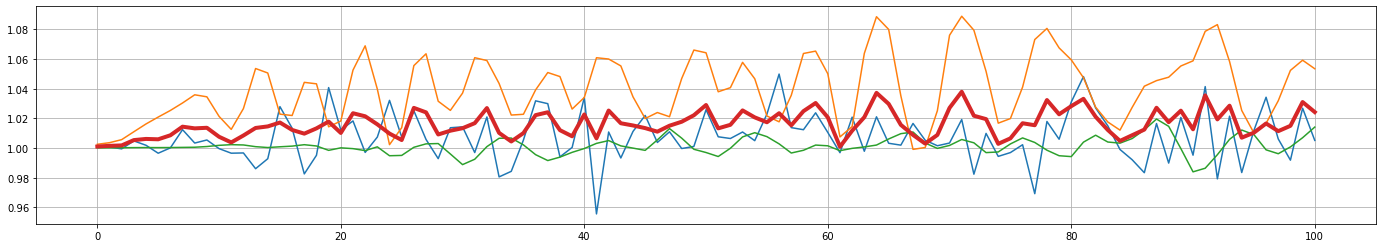

In [11]:
plt.figure(figsize = (24, 4), facecolor='w')
plt.grid()

layer = '0'
pos = '19'
data1 = np.array([usefulness_per_neuron[e][f'{layer} {pos}'] for e in usefulness_per_neuron])

layer = '0'
pos = '94'
data2 = np.array([usefulness_per_neuron[e][f'{layer} {pos}'] for e in usefulness_per_neuron])
pos = '82'
data3 = np.array([usefulness_per_neuron[e][f'{layer} {pos}'] for e in usefulness_per_neuron])
plt.plot(data1)
plt.plot(data2)
plt.plot(data3)
plt.plot((data1+data2+data3)/3, linewidth = 4)

In [24]:
import numpy.fft as fft
import scipy 
import scipy.fftpack 

In [111]:
def find_period(data):
    a=np.abs(fft.rfft(data))
    #Not sure if this is a good idea but seems to help with choppy data..
    a[0] = 0
    freqs = fft.rfftfreq(n=data.size, d=1)
    freqs = np.divide(1,freqs)
    max_freq = freqs[np.argmax(a)]
    return(max_freq)

In [155]:
layer = '2'
periods = []
for pos in range(100):
    pos = str(pos)
    data = np.array([usefulness_per_neuron[e][f'{layer} {pos}'] for e in usefulness_per_neuron])
    period_time = find_period(data)
    periods += [(period_time, pos)]
    
periods = np.array(periods, dtype=float)

/home/levai/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  


(array([ 0.,  0.,  8.,  7.,  1.,  7., 17., 13., 13.,  5.,  6.,  0.,  0.,
         0.,  2.,  0.,  0.,  0.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18.]),
 <a list of 18 Patch objects>)

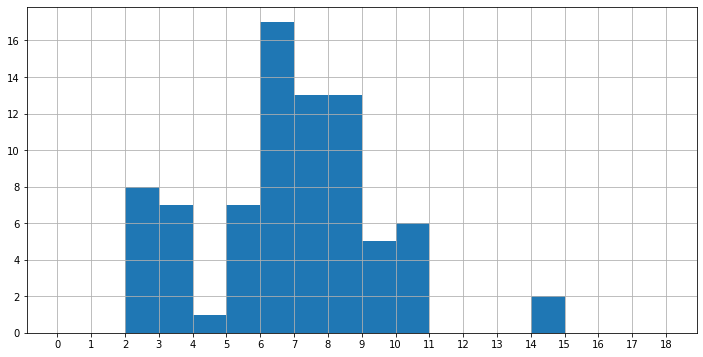

In [156]:
plt.figure(figsize = (12, 6))
# fig, ax = plt.subplots()
plt.grid()
bins = np.linspace(0, 18, 19)
plt.xticks(bins)
plt.yticks(range(0, 25, 2))
plt.hist(periods[:, 0].astype(float), bins = bins)




In [180]:
layers = [str(x) for x in range(5)]
all_periods = []
for layer in layers:
    periods = []
    for pos in range(100):
        pos = str(pos)
        data = np.array([usefulness_per_neuron[e][f'{layer} {pos}'] for e in usefulness_per_neuron])
        period_time = find_period(data)
        periods += [period_time]



    all_periods += [periods]
    # fig, ax = plt.subplots()
all_periods = np.array(all_periods, dtype = float).T

/home/levai/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  


In [227]:
print(plt.style.available)
plt.style.use('ggplot')
#plt.style.use('seaborn-whitegrid')

['ggplot', 'seaborn-deep', 'tableau-colorblind10', 'grayscale', 'seaborn', 'seaborn-pastel', 'seaborn-muted', 'Solarize_Light2', 'seaborn-talk', 'seaborn-white', 'classic', 'seaborn-bright', 'fast', 'dark_background', '_classic_test', 'bmh', 'seaborn-dark', 'seaborn-notebook', 'seaborn-paper', 'seaborn-colorblind', 'seaborn-poster', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-ticks', 'fivethirtyeight', 'seaborn-whitegrid']


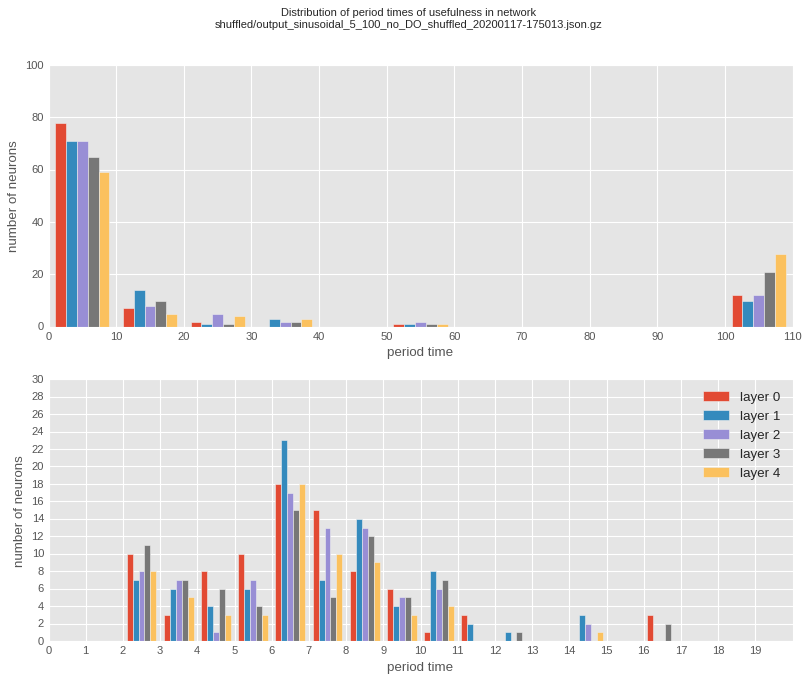

In [235]:
plt.figure(figsize = (12, 9))
plt.suptitle(f'Distribution of period times of usefulness in network\n{fname}')
plt.subplot(211)
bins = np.arange(0, 111, 10)
plt.ylim(0, 100)
plt.xlim(0, 110)
plt.hist(all_periods, bins, label = [f'layer {l}' for l in layers])
plt.xticks(bins)
plt.xlabel('period time')
plt.ylabel('number of neurons')
plt.grid(b=True)
plt.subplot(212)
# plt.hist(periods[:, 0].astype(float), bins = bins, alpha=1, linewidth = 5, histtype = 'stepfilled', label = f'layer {layer}')
plt.grid(b=True)
bins = np.arange(0, 20, 1)
plt.xticks(bins)
plt.yticks(range(0, 31, 2))
plt.ylim(0, 30)
plt.xlim(0, 20)
plt.xlabel('period time')
plt.ylabel('number of neurons')
plt.hist(all_periods, histtype='bar', bins = bins, label = [f'layer {l}' for l in layers])


plt.legend()
plt.savefig('test.png', dpi=300)


/home/levai/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys


max freq:6.5


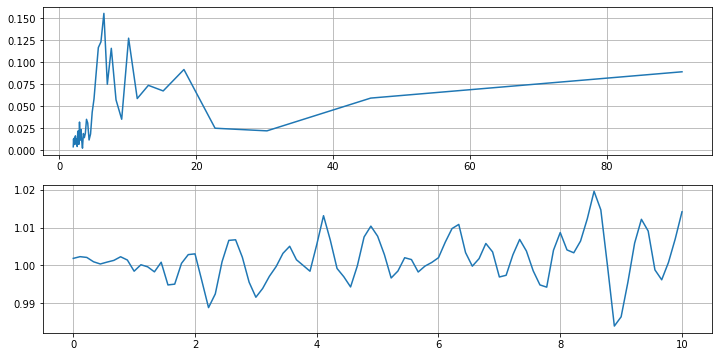

[0.         0.08893172 0.05905952 0.02185729 0.0248366  0.09150513
 0.06720276 0.07355049 0.05853843 0.12710708 0.03504275 0.05705603
 0.11559202 0.07473974 0.15526765 0.12290041 0.11641625 0.08602178
 0.05816811 0.04296833 0.018375   0.01148359 0.03076172 0.03495482
 0.01908557 0.01411279 0.01879975 0.00220318 0.01138379 0.02350077
 0.01129236 0.03184119 0.00657332 0.02191952 0.02048817 0.00403985
 0.01261804 0.00777769 0.01138118 0.01617103 0.00660125 0.01422843
 0.01041042 0.00615897 0.01272108 0.00379565]


In [108]:
data = data3[10:]

a=np.abs(fft.rfft(data))
#Not sure if this is a good idea but seems to help with choppy data..
a[0] = 0
freqs = fft.rfftfreq(n=data.size, d=1)
freqs = np.divide(1,freqs)
max_freq = freqs[np.argmax(a)]
print(f'max freq:{max_freq}')
temporal_window = 10
plt.figure(figsize = (12,6))
plt.subplot(211)
plt.grid()
plt.plot(freqs,a)
plt.subplot(212)
plt.plot(np.linspace(0,temporal_window,data.size),data)
plt.grid()
plt.show()
print(a)

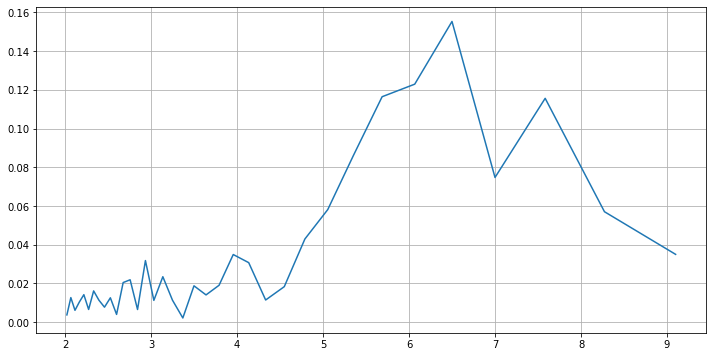

In [109]:
plt.figure(figsize = (12,6))
plt.grid()
plt.plot(freqs[10:],a[10:])

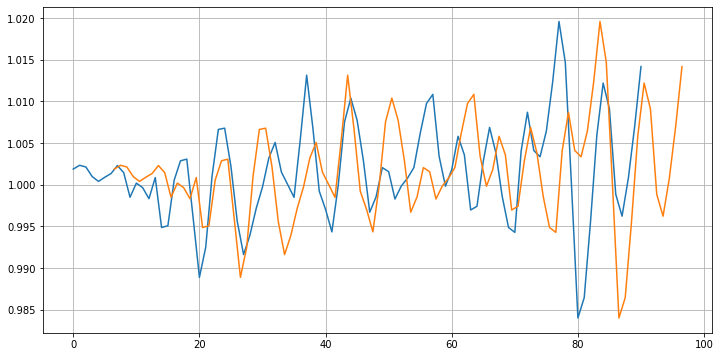

In [110]:
plt.figure(figsize = (12,6))
plt.grid()
plt.plot(range(len(data)), data)

plt.plot(np.array(range(len(data)))+max_freq, data)

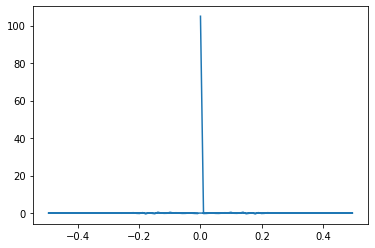

In [34]:
plt.plot(freqs, FFT)